In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from glob import glob
from google.colab import drive
import os
import pandas as pd
drive.mount("/content/gdrive")

sr=16000

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def readDir(filename, Fs):
    x , sr = librosa.load(filename , sr = Fs)
    return x

In [ ]:
def readSpectrogram(infilename):
    X = np.load(infilename)
    return X

In [ ]:
def zero_pad(x):
    curr_len = np.size(x)
    #Making the duration exactly 10 sec
    if curr_len > 160000:
        x = x[0:160000]
    else:
        x = np.pad(x, (0, 160000-curr_len), 'constant')
    return x

In [ ]:
def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = complex))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

In [ ]:
def label_framewise(arr):
    #generate framewise one hot vectors for 3 classes(music,silence, speech)
    hop_len = 512
    win_length = 1024
    Fs = 16000
    no_of_events, x = np.shape(arr)
    x = np.array([[0,1,0]]*313)

    for i in range(no_of_events):
      start_frame = round((arr[i][0]*Fs - win_length)/(hop_len)+1)
      end_frame = round((arr[i][1]*Fs - win_length)/(hop_len)+1)
      curr_class = arr[i][2]

      if curr_class == 0: #music class
        x[int(start_frame):int(end_frame)+1] = [1,0,0]
      if curr_class == 2: #speech class
        x[int(start_frame):int(end_frame)+1] = [0,0,1]
      
      
    return x

In [ ]:
def frame_to_time(m):
    hop_len = 512
    win_length = 1024
    Fs = 16000
    return ((m-1)*hop_len+win_length)/Fs

In [ ]:
if __name__=="__main__":
    
    Fs = 16000
    curr_folder = '/content/gdrive/My Drive/wav_folder'
    path = os.path.join(curr_folder, '*.wav')
    folder = glob(path)

    file_count = 0
    for file in folder:
        file_count = file_count + 1
    
    csv_file = '/content/gdrive/My Drive/wav_folder/labels.csv'
    df = pd.read_csv(csv_file)
    df = df.to_numpy()    

    file_list = os.listdir(curr_folder)
    file_name_list = df[:,0]

    feature_per_frame = 513
    frame_per_file = 313

    X_train = np.zeros((feature_per_frame,frame_per_file*file_count))
    Y_train = np.array([[0,1,0]]*frame_per_file*file_count)
    
    start = 0
    end = frame_per_file
    
    i = 0
    for file in folder:
        x_data = readDir(file,Fs)
        curr_len = np.size(x_data)
        #data preprocessing
        x_data = zero_pad(x_data)
        
        curr_spectrogram = calc_spec(x_data)
        X_train[:, start:end] = curr_spectrogram

        curr_file = (file_list[i])
        curr_file = curr_file[0:len(curr_file)-4]
        file_index = np.where(file_name_list == curr_file)
        event_count = np.size(file_index)
        timestamp_array = np.ones((event_count,3))
        
        for event in range(event_count):
            curr_index = file_index[0][event]
            onset = df[curr_index][1]
            offset =  df[curr_index][2]
            curr_class = df[curr_index][3]

            timestamp_array[event][0] = onset
            timestamp_array[event][1] = offset

            if curr_class == 'music':
                timestamp_array[event][2] = 0
            if curr_class == 'speech':
                timestamp_array[event][2] = 2

        curr_label = label_framewise(timestamp_array)
        Y_train[start:end,:] = curr_label

        start = end
        end = end + frame_per_file
        i = i + 1
    
    X_train=np.transpose(X_train)
    print(np.shape(X_train))
    print(np.shape(Y_train))

(9390, 513)
(9390, 3)


In [ ]:
sum_silence=np.zeros(513)
sum_speech=np.zeros(513)
sum_music=np.zeros(513)
freq_silence=0
freq_speech=0
freq_music=0

In [ ]:
for i in range(0, np.shape(X_train)[0]):
  if Y_train[i][0]==1:
    freq_music+=1
    sum_music+=X_train[i,:]
  if Y_train[i][1]==1:
    freq_silence+=1
    sum_silence+=X_train[i,:]
  if Y_train[i][2]==1:
    freq_speech+=1
    sum_speech+=X_train[i,:]

mean_speech=sum_speech/freq_speech
mean_silence=sum_music/freq_music
mean_music=sum_silence/freq_silence

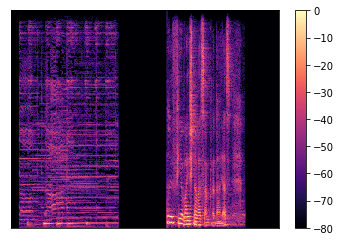

In [ ]:
#sample test data whose ground-truth is known
z=readSpectrogram('/content/gdrive/My Drive/spectrogram_folder/test2.npy')
plt.figure()
librosa.display.specshow(z)
plt.colorbar()

In [ ]:
z=10**(z/10)
s=np.sum(z,axis=0)
loc=np.where(s<0.001,0,1) # 1- Not Silent, 0- Silent
print(loc)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
#TASK 1 - Event Detection
start=0
end=0
list1=[]
for i in range(0,len(loc)):
  if i==0 and loc[i]==1:
    start=0
    end=0
  elif loc[i]==0:
    if(start != end):
      list1.append([start, end])
    start=loc[i]
    end=start
  elif loc[i]==1 and loc[i-1]==0:
    start=i
    end=start
  elif loc[i]==1 and loc[i-1]==1:
    end=end+1
event_count = len(list1)
arr2 = np.zeros((event_count,2))
for i in range(event_count):
    onset = frame_to_time(list1[i][0])
    offset = frame_to_time(list1[i][1])

    arr2[i][0] = onset
    arr2[i][1] = offset
print(list1)
print(arr2)
#arr2 contains the onset and offset times for every event in a 10 sec audio

[[10, 125], [182, 273]]
[[0.352 4.032]
 [5.856 8.768]]


In [ ]:
label=[]
for j in range(0,len(list1)):
  segment=np.transpose(z[:,list1[j][0]:list1[j][1]])
  cnt_si=0
  cnt_sp=0
  cnt_mu=0
  for i in range(0, np.shape(segment)[0]):
    dist_si= np.linalg.norm(segment[i]-mean_silence)
    dist_sp= np.linalg.norm(segment[i]-mean_speech)
    dist_mu= np.linalg.norm(segment[i]-mean_music)

    if max(dist_mu,dist_si,dist_sp)==dist_mu:
      cnt_mu=cnt_mu+1
    if max(dist_mu,dist_si,dist_sp)==dist_sp:
      cnt_sp=cnt_sp+1
    if max(dist_mu,dist_si,dist_sp)==dist_si:
      cnt_si=cnt_si+1

  if max(cnt_si,cnt_sp,cnt_mu)==cnt_mu:
    label.append('music')
  if max(cnt_si,cnt_sp,cnt_mu)==cnt_si:
    label.append('silence')
  if max(cnt_si,cnt_sp,cnt_mu)==cnt_sp:
    label.append('speech')

print(label)

['music', 'music']
